In [22]:
# Libraries
import torch
import math
from tqdm import trange
from slips.distributions.mog import CircularMixture
from slips.samplers.mcmc import MCMCScoreEstimator
from slips.samplers.sto_loc import sto_loc_algorithm, sample_y_init
from slips.samplers.alphas import *
import matplotlib.pyplot as plt

In [23]:
# Make a Pytorch device
device = torch.device('cuda')

In [24]:
# Make the target distribution
target = CircularMixture(device)

In [25]:
# Select one alpha
alpha = AlphaGeometric(a=1.0, b=1.0)

In [26]:
# Get the score of the target distribution
def target_log_prob_and_grad(y):
    y_ = torch.autograd.Variable(y, requires_grad=True)
    log_prob_y = target.log_prob(y_)
    return log_prob_y, torch.autograd.grad(log_prob_y.sum(), y_)[0].detach()

In [27]:
# Set sigma
sigma = torch.tensor(5.0)

In [32]:
# Hyper-parameters
n_samples = 2048
K = 1024
n_mcmc_steps = 32
n_mcmc_chains = 4
epsilon, epsilon_end, T = 0.35, 6.62e-03, 1.0

In [29]:
# Prepare the score estimator
score_est = MCMCScoreEstimator(
    step_size=1e-5,
    n_mcmc_samples=n_mcmc_steps,
    log_prob_and_grad=target_log_prob_and_grad,
    n_mcmc_chains=n_mcmc_chains,
    keep_mcmc_length=int(0.5 * n_mcmc_steps)
)

In [30]:
# Sample the initial point with Langevin-within-Langevin
y_init = sample_y_init((n_samples, 2), sigma=sigma, epsilon=epsilon, alpha=alpha, device=device,
        n_langevin_steps=32, langevin_init=True, score_est=score_est, score_type='mc')

In [33]:
# Run the SLIPS algorithm
samples = sto_loc_algorithm(alpha=alpha, y_init=y_init, K=K, T=T, sigma=sigma, score_est=score_est, score_type='mc',
    epsilon=epsilon, epsilon_end=epsilon_end, use_exponential_integrator=True, use_snr_discretization=True,
    verbose=True
).detach().cpu()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1023/1023 [01:09<00:00, 14.75it/s]


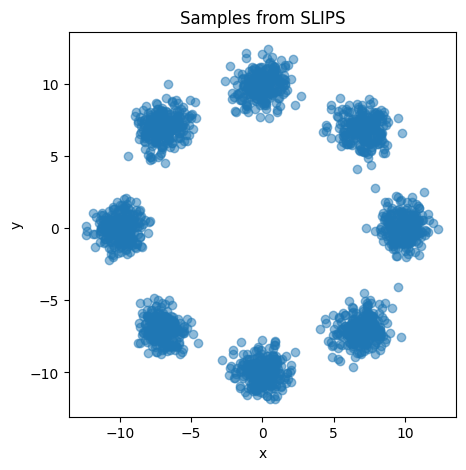

In [35]:
# Display samples
plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from SLIPS')
plt.show()

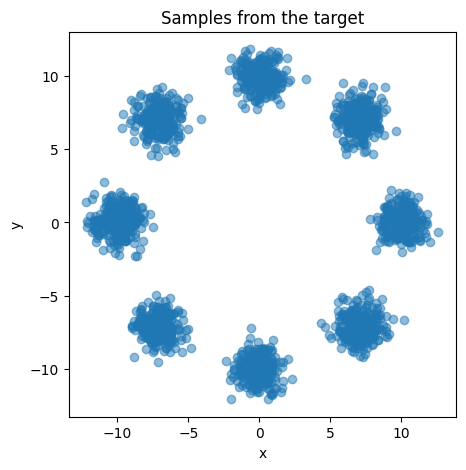

In [36]:
# Display target samples
plt.figure(figsize=(5,5))
target_samples = target.sample((samples.shape[0],)).cpu()
plt.scatter(target_samples[:,0], target_samples[:,1], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from the target')
plt.show()